Rank categories: ['Top 10' 'Top 100' 'Top 200' 'Top 50']
Epoch 1/50, Loss: 0.957908, Accuracy: 0.5889
Epoch 2/50, Loss: 0.617794, Accuracy: 0.7375
Epoch 3/50, Loss: 0.562361, Accuracy: 0.7532
Epoch 4/50, Loss: 0.542702, Accuracy: 0.7603
Epoch 5/50, Loss: 0.546368, Accuracy: 0.7617
Epoch 6/50, Loss: 0.531415, Accuracy: 0.7624
Epoch 7/50, Loss: 0.525246, Accuracy: 0.7628
Epoch 8/50, Loss: 0.525474, Accuracy: 0.7658
Epoch 9/50, Loss: 0.520744, Accuracy: 0.7655
Epoch 10/50, Loss: 0.523280, Accuracy: 0.7652
Epoch 11/50, Loss: 0.524012, Accuracy: 0.7645
Epoch 12/50, Loss: 0.510683, Accuracy: 0.7684
Epoch 13/50, Loss: 0.515728, Accuracy: 0.7676
Epoch 14/50, Loss: 0.510039, Accuracy: 0.7696
Epoch 15/50, Loss: 0.512223, Accuracy: 0.7658
Epoch 16/50, Loss: 0.506433, Accuracy: 0.7681
Epoch 17/50, Loss: 0.512963, Accuracy: 0.7656
Epoch 18/50, Loss: 0.504128, Accuracy: 0.7671
Epoch 19/50, Loss: 0.510264, Accuracy: 0.7679
Epoch 20/50, Loss: 0.510573, Accuracy: 0.7678
Epoch 21/50, Loss: 0.502801, Acc

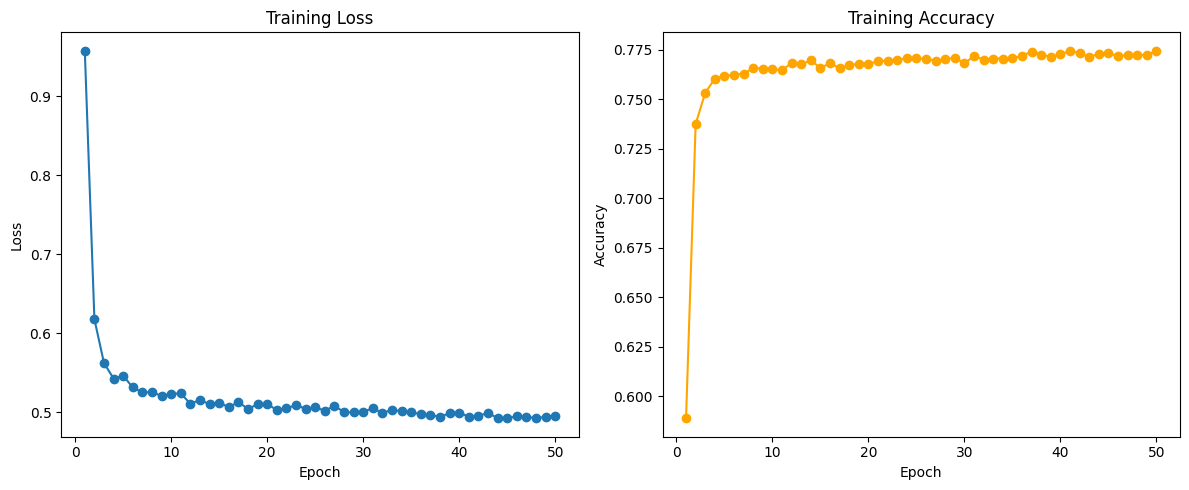

Test Accuracy: 0.8883
预测步数（月数差）： 9
类别映射 (encoded: avg normalized Hours_watched): {np.int64(0): np.float64(0.19450952789738715), np.int64(1): np.float64(0.005148985476368703), np.int64(2): np.float64(0.0017070464486289494), np.int64(3): np.float64(0.0240167101981871)}
预测未来 2025.6 的 Rank: Top 200


In [98]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

# -----------------------------
# 1. 数据加载与预处理
# -----------------------------
df = pd.read_csv("data.csv")

# 按 Year 和 Month 排序，确保时间序列顺序正确
df = df.sort_values(by=["Year", "Month"]).reset_index(drop=True)

# 对 rank_category 进行编码（例如：['Top 10', 'Top 100', 'Top 200', 'Top 50']）
label_encoder = LabelEncoder()
df["rank_category_encoded"] = label_encoder.fit_transform(df["rank_category"])
num_classes = len(label_encoder.classes_)
print("Rank categories:", label_encoder.classes_)

# 选择 "Hours_watched" 作为输入特征，并转换为 float 类型
data_feature = df[["Hours_watched"]].values.astype(float)
data_target = df["rank_category_encoded"].values

# 对 Hours_watched 归一化
scaler = MinMaxScaler(feature_range=(0, 1))
data_feature_scaled = scaler.fit_transform(data_feature)

# 构造时间序列数据：每 seq_length 个月作为输入，目标为下一个月的 rank_category
def create_sequences(features, labels, seq_length):
    sequences, targets = [], []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i+seq_length])
        targets.append(labels[i+seq_length])
    return np.array(sequences), np.array(targets)

# 设置时间窗口长度，例如 12 个月
seq_length = 12
X, y = create_sequences(data_feature_scaled, data_target, seq_length)

# 划分训练集与测试集（80% 训练，20% 测试）
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -----------------------------
# 2. 构建 LSTM 分类模型
# -----------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, num_classes=4):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        # 取最后一个时间步的输出，然后全连接输出各类别得分
        out = self.fc(out[:, -1, :])
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(input_size=1, hidden_size=50, num_layers=2, num_classes=num_classes).to(device)

# -----------------------------
# 3. 训练模型并记录训练过程
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
        
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}, Accuracy: {epoch_accuracy:.4f}')

# 绘制训练曲线
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, marker='o', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

# -----------------------------
# 4. 测试集评估
# -----------------------------
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total_test += batch_y.size(0)
        correct_test += (predicted == batch_y).sum().item()

test_accuracy = correct_test / total_test
print("Test Accuracy: {:.4f}".format(test_accuracy))

# -----------------------------
# 5. 利用训练好的模型预测未来某月的 Rank
# -----------------------------
# 目标月份（例如预测 2025 年 6 月的 Rank）
target_year = 2025
target_month = 6

# 获取历史数据最后一条记录的年份和月份（假设历史数据中的最后一行为最新记录）
last_year = df['Year'].iloc[-1]
last_month = df['Month'].iloc[-1]
# 计算从最后记录到目标月份的月份差
months_diff = (target_year - last_year) * 12 + (target_month - last_month)
print("预测步数（月数差）：", months_diff)

# 构造类别映射：
# 利用归一化后的 Hours_watched 计算每个类别的平均值，作为该类别的代表归一化值
df['Hours_watched_norm'] = scaler.transform(df[['Hours_watched']])
category_mapping = {}
for cat in np.unique(df['rank_category_encoded']):
    avg_norm = df[df['rank_category_encoded'] == cat]['Hours_watched_norm'].mean()
    category_mapping[cat] = avg_norm
print("类别映射 (encoded: avg normalized Hours_watched):", category_mapping)

# 从构造的序列 X 中取最后一个序列作为初始输入，形状为 (1, seq_length, 1)
last_sequence = X[-1]
last_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

predicted_rank = None  # 用于存储最新预测类别

# 迭代预测 months_diff 步，模拟每个月的预测
for _ in range(months_diff):
    with torch.no_grad():
        outputs = model(last_sequence)
        _, predicted = torch.max(outputs.data, 1)
        predicted_rank = predicted.item()
    # 利用类别映射获得该类别对应的平均归一化值
    predicted_norm_value = category_mapping[predicted_rank]
    # 构造形状 (1, 1, 1) 的张量作为新的预测值
    predicted_tensor = torch.tensor([[[predicted_norm_value]]], dtype=torch.float32).to(device)
    # 将序列向前滚动一位，并将最新预测值附加到序列末尾
    last_sequence = torch.cat((last_sequence[:, 1:, :], predicted_tensor), dim=1)

# 将预测类别转换回原始标签
predicted_rank_label = label_encoder.inverse_transform([predicted_rank])[0]
print(f"预测未来 {target_year}.{target_month} 的 Rank: {predicted_rank_label}")


Confusion Matrix:
[[ 188    0   20    0]
 [   0  776   17  257]
 [   0  175 1925    0]
 [   0    0    0  840]]


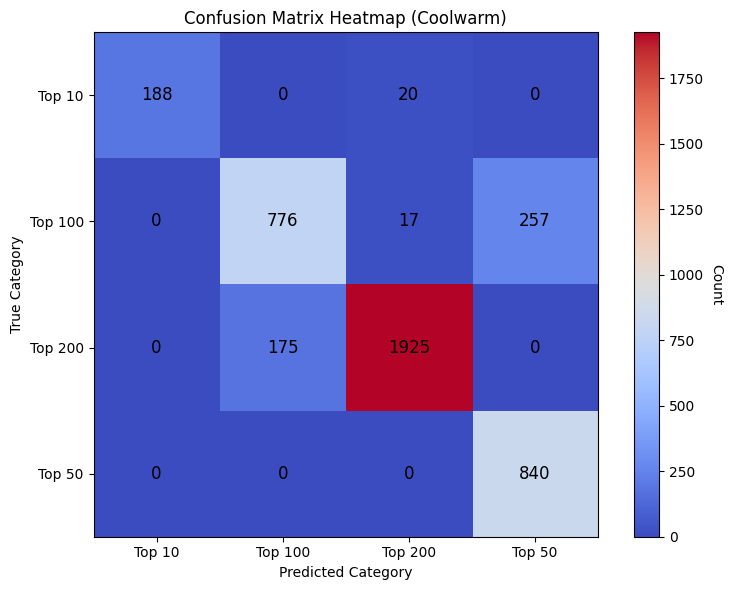

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 预测测试集所有数据
model.eval()
all_true = []
all_pred = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        all_true.extend(batch_y.cpu().numpy())
        all_pred.extend(predicted.cpu().numpy())

# 计算混淆矩阵
cm = confusion_matrix(all_true, all_pred)
print("Confusion Matrix:")
print(cm)

# 定义类别标签
categories = label_encoder.inverse_transform(np.arange(num_classes))

# 使用 matplotlib 绘制热力图，采用 coolwarm 配色方案
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap="coolwarm")

# 添加颜色条
cbar = plt.colorbar(im)
cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")

# 设置 x、y 轴刻度和标签
ax.set_xticks(np.arange(len(categories)))
ax.set_yticks(np.arange(len(categories)))
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)

# 标注每个单元格的数值
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"), ha="center", va="center", color="black", fontsize=12)

ax.set_xlabel("Predicted Category")
ax.set_ylabel("True Category")
ax.set_title("Confusion Matrix Heatmap (Coolwarm)")
plt.tight_layout()
plt.show()


         precision    recall  f1-score  support
Top 10    1.000000  0.903846  0.949495    208.0
Top 100   0.815983  0.739048  0.775612   1050.0
Top 200   0.981142  0.916667  0.947809   2100.0
Top 50    0.765725  1.000000  0.867321    840.0


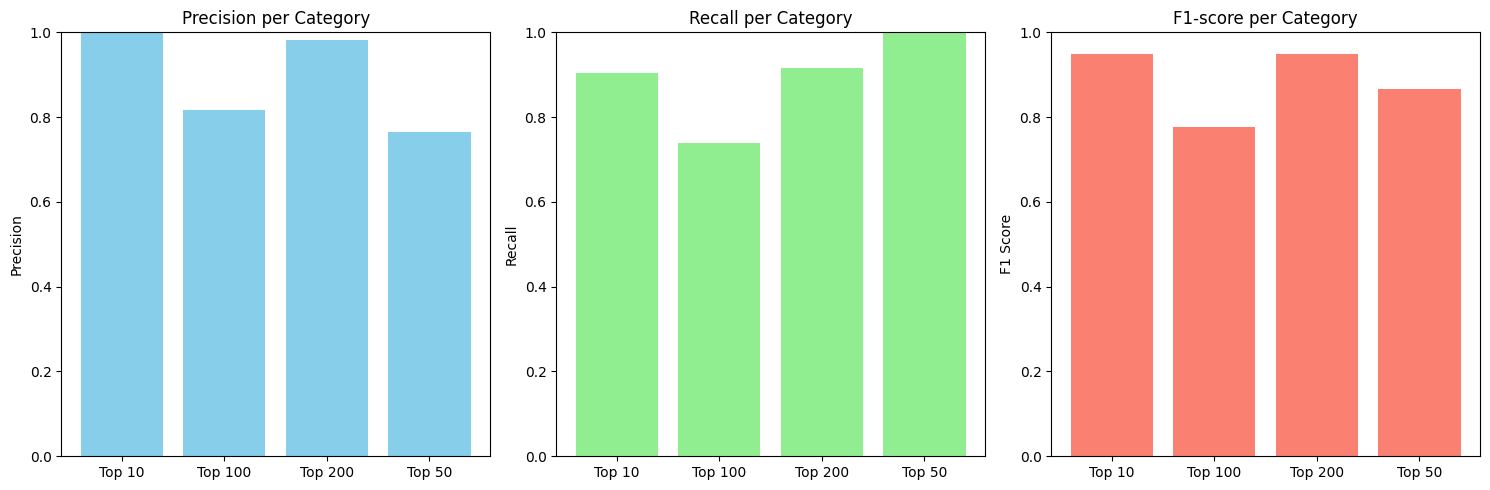

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# 计算分类报告，输出为字典格式
report_dict = classification_report(all_true, all_pred, target_names=categories, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
# 只保留各类别的指标（排除 'accuracy', 'macro avg', 'weighted avg'）
report_df = report_df.loc[categories]
print(report_df)

# 绘制 Precision, Recall, F1-score 的条形图
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Precision
ax[0].bar(report_df.index, report_df['precision'], color='skyblue')
ax[0].set_title('Precision per Category')
ax[0].set_ylim(0, 1)
ax[0].set_ylabel('Precision')

# Recall
ax[1].bar(report_df.index, report_df['recall'], color='lightgreen')
ax[1].set_title('Recall per Category')
ax[1].set_ylim(0, 1)
ax[1].set_ylabel('Recall')

# F1-score
ax[2].bar(report_df.index, report_df['f1-score'], color='salmon')
ax[2].set_title('F1-score per Category')
ax[2].set_ylim(0, 1)
ax[2].set_ylabel('F1 Score')

plt.tight_layout()
plt.show()


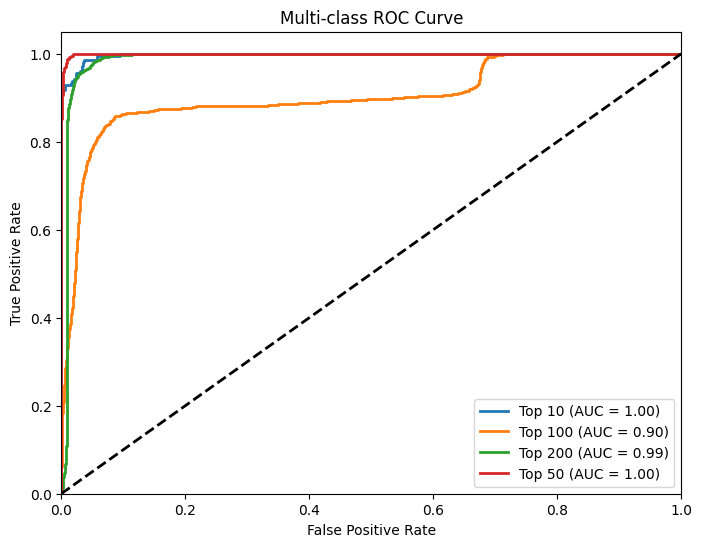

In [103]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 预测测试集所有数据，获得每个类别的概率输出
model.eval()
all_true = []
all_prob = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        prob = F.softmax(outputs, dim=1)  # 转换为概率
        all_true.extend(batch_y.cpu().numpy())
        all_prob.append(prob.cpu().numpy())

all_prob = np.concatenate(all_prob, axis=0)
all_true = np.array(all_true)

# 对真实标签进行二值化处理，方便计算每个类别的 ROC 曲线
all_true_binarized = label_binarize(all_true, classes=np.arange(num_classes))

# 计算每个类别的 FPR, TPR 以及 AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_true_binarized[:, i], all_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制每个类别的 ROC 曲线
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()
